In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
box = pd.read_csv('/content/gdrive/MyDrive/food_csv/갈비탕.csv')
box.head()

,0,1,2,3,4
0,side_건더기국류_뚝배기_갈비탕_Q1_00001.JPG,740,975,1506,1258
1,side_건더기국류_뚝배기_갈비탕_Q1_00002.JPG,774,799,1526,1157
2,side_건더기국류_뚝배기_갈비탕_Q1_00003.JPG,870,715,1629,1064
3,side_건더기국류_뚝배기_갈비탕_Q1_00004.JPG,902,806,1637,1098
4,side_건더기국류_뚝배기_갈비탕_Q1_00005.JPG,949,855,1710,1096


In [ ]:
box.columns = ['image', 'xmin', 'ymin', 'xmax', 'ymax']
box.head()

,image,xmin,ymin,xmax,ymax
0,side_건더기국류_뚝배기_갈비탕_Q1_00001.JPG,740,975,1506,1258
1,side_건더기국류_뚝배기_갈비탕_Q1_00002.JPG,774,799,1526,1157
2,side_건더기국류_뚝배기_갈비탕_Q1_00003.JPG,870,715,1629,1064
3,side_건더기국류_뚝배기_갈비탕_Q1_00004.JPG,902,806,1637,1098
4,side_건더기국류_뚝배기_갈비탕_Q1_00005.JPG,949,855,1710,1096


image    side_건더기국류_뚝배기_갈비탕_Q1_00001.JPG
xmin                                                 740
ymin                                                 975
xmax                                                1506
ymax                                                1258
Name: 0, dtype: object


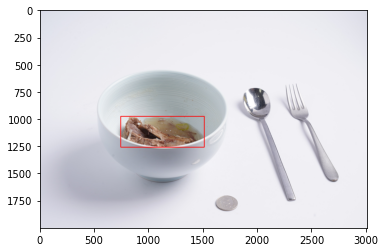

In [ ]:
sample = cv2.imread('/content/gdrive/MyDrive/DCD_2022/음식 이미지 및 영양정보 텍스트/Classification_Train/갈비탕/side_건더기국류_뚝배기_갈비탕_Q1_00001.JPG')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
point = box.iloc[0]
print(point)
pt1 = (int(point['xmin']), int(point['ymax']))
pt2 = (int(point['xmax']), int(point['ymin']))
cv2.rectangle(sample, pt1, pt2, color=(255,0,0), thickness=5)
plt.imshow(sample)
plt.show()

In [ ]:
image_dir = "/content/gdrive/MyDrive/DCD_2022/음식 이미지 및 영양정보 텍스트/Classification_Train/갈비탕"

image_ids = box["image"].unique()
image_id = image_ids[0]
print(image_id)
image = cv2.imread(image_dir + '/' + image_id, cv2.IMREAD_COLOR)
image.shape

side_건더기국류_뚝배기_갈비탕_Q1_00001.JPG


(2000, 3008, 3)

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, df, image_dir, transforms=None):
        super().__init__()
        self.image_ids = df["image"].unique() # all image filenames
        self.df = df
        self.image_dir = image_dir # dir to image files
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        records = self.df[self.df["image"] == image_id]
        image = cv2.imread(self.image_dir + '/' + image_id, cv2.IMREAD_COLOR)
        heights, widths = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = torch.tensor(image)
        image = image.permute(2,0,1)
        
        
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        masks = []
        for box in boxes:
            mask = np.zeros([int(heights), int(widths)], np.uint8)
            masks.append(cv2.rectangle(mask, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 1, -1))

        masks = torch.tensor(masks, dtype=torch.uint8)

        # class가 1종류이기 때문에 label은 1로만 지정
        labels = torch.ones((records.shape[0]), dtype=torch.int64)
        
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["labels"] = labels
        target['masks'] = masks
        target["image_id"] = torch.tensor([idx])
        target["area"] = area


        if self.transforms:
            sample = {"image": image, "boxes": target["boxes"], "labels": labels}
            sample = self.transforms(**sample)
            image = sample["image"]
            target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["boxes"])))).permute(1, 0)

        return image, target

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dir_train = "/content/gdrive/MyDrive/DCD_2022/음식 이미지 및 영양정보 텍스트/Classification_Train/갈비탕"
train_ds = FoodDataset(box, dir_train)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [ ]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
num_classes = 2

model = get_instance_segmentation_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model.train()

num_epochs = 5

for epoch in range(num_epochs):
    
    for i, (images, targets) in enumerate(train_dl):
      optimizer.zero_grad()
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())

      losses.backward()
      optimizer.step()

      if (i+1) % 40 == 0:
        print(f'Epoch {epoch+1} - Total: {losses:.4f}, Regression: {loss_dict["loss_box_reg"]:.4f}, Classifier: {loss_dict["loss_classifier"]:.4f}')

    scheduler.step()

Epoch 1 - Total: 0.3392, Regression: 0.0306, Classifier: 0.0382
Epoch 2 - Total: 0.2639, Regression: 0.0507, Classifier: 0.0355
Epoch 3 - Total: 0.1533, Regression: 0.0257, Classifier: 0.0318
Epoch 4 - Total: 0.1341, Regression: 0.0296, Classifier: 0.0274
Epoch 5 - Total: 0.1240, Regression: 0.0168, Classifier: 0.0219


In [ ]:
threshold = 0.8

In [ ]:
images = cv2.imread("/content/gdrive/MyDrive/9f2dce6e653f522a37c4e8024599b784.jpg", cv2.IMREAD_COLOR)
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images /= 255.0
sample = images
images = torch.tensor(images)
images = images.permute(2,0,1)
images = torch.unsqueeze(images, 0)
images = images.to(device)
model.eval()
cpu_device = torch.device("cpu")

preds = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in preds]
mask = outputs[0]['scores'] > threshold
boxes = outputs[0]["boxes"][mask].detach().numpy().astype(np.int32)

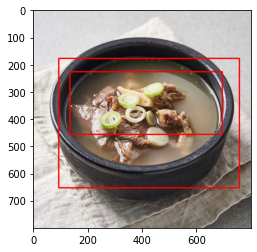

In [ ]:
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
plt.imshow(sample)
plt.show()